Reproduce: SimPEG Cylindrical Mesh
===============================

## Simulating Transient TEM Data over a Conductive Layered Earth

Transient TEM data are simulated over a conductive 1D layered Earth. From the top layer down we define 3 layers with electrical conductivities $\sigma_1$ = 0.01 S/m, $\sigma_2$ = 0.1 S/m and $\sigma_3$ = 0.01 S/m. The thicknesses of the top two layers are both 64 m.

The transient response is simulated for a horizontal transmitter loop centered at (0, 0, 5) with a radius of 2 m. The x, y and z components of H and dB/dt are simulated at (10, 0, 5). We only plot the x and z components because the y component is null-coupled.

## SimPEG Package Details

**Link to the docstrings for the simulation.** The docstrings will have a citation and show the integral equation.

## Reproducing the Forward Simulation Result

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from discretize.utils import mkvc, ndgrid
from discretize import CylindricalMesh
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from SimPEG.utils import model_builder
from pymatsolver import Pardiso

import numpy as np
import scipy.special as spec
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size':16})

write_output = True

A compressed folder containing the assets required to run the notebook is then downloaded. This includes mesh and model files for the forward simulation.

In [2]:
# Download .tar files

Extracted files are then loaded into the SimPEG framework.

In [3]:
rootdir = './../../../assets/tdem/layered_earth_conductive_fwd_simpeg/'

Here, we define the survey geometry for the forward simulation.

In [4]:
xyz_tx = np.c_[0., 0., 5.]           # Transmitter location
xyz_rx = np.c_[10., 0., 5.]          # Receiver location
loop_radius = 2.                     # Loop Radius
times = np.logspace(-5,-2,10)        # Times

waveform = tdem.sources.StepOffWaveform(offTime=0.0)

receivers_list = [
    tdem.receivers.PointMagneticField(xyz_rx, times, "x"),
    tdem.receivers.PointMagneticField(xyz_rx, times, "z"),
    tdem.receivers.PointMagneticFluxTimeDerivative(xyz_rx, times, "x"),
    tdem.receivers.PointMagneticFluxTimeDerivative(xyz_rx, times, "z")
]

source_list = [
    tdem.sources.CircularLoop(
        receivers_list, location=mkvc(xyz_tx), waveform=waveform, radius=loop_radius, orientation="z"
    )
]

survey = tdem.Survey(source_list)

Below, we define the mesh used in the forward simulation.

In [5]:
thicknesses = np.r_[64., 64]         # thicknesses
sigma = np.r_[0.01, 0.1, 0.01]       # conductivity

hr = [(2., 50), (2., 25, 1.05), (2.*1.05**25, 30, 1.1)]
hz = [(2.*1.05**25, 30, -1.1), (2., 25, -1.05), (2., 40), (2., 25, 1.05), (2.*1.05**25, 30, 1.1)]
mesh = CylindricalMesh([hr, 1, hz], x0="00C")

Here we define and plot the conductivity model used in the forward simulation.

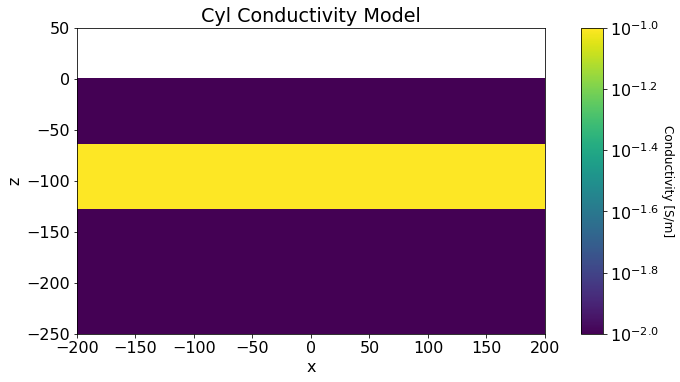

In [6]:
ind_active = mesh.cell_centers[:, 2] < 0
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
sigma_map = maps.IdentityMap(nP=mesh.nC)
sigma_model = 1e-8 * np.ones(mesh.nC)
sigma_model[mesh.cell_centers[:,2]<0] = sigma[-1]
k = (mesh.cell_centers[:, 2] < 0) & (mesh.cell_centers[:, 2] > -np.sum(thicknesses))
sigma_model[k] = sigma[1]
k = (mesh.cell_centers[:, 2] < 0) & (mesh.cell_centers[:, 2] > -thicknesses[0])
sigma_model[k] = sigma[0]

fig = plt.figure(figsize=(10, 5))
log_model = np.log10(sigma_model[ind_active])

ax1 = fig.add_axes([0.15, 0.1, 0.65, 0.85])
mesh.plot_image(
    plotting_map * log_model,
    mirror=True,
    ax=ax1,
    grid=False,
    clim=(np.log10(np.min(sigma)), np.log10(np.max(sigma))),
)

ax1.set_xlim([-200, 200])
ax1.set_ylim([-250, 50])
ax1.set_title("Cyl Conductivity Model")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(
    vmin=np.log10(np.min(sigma)), vmax=np.log10(np.max(sigma))
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

Here we define the mapping from the model to the mesh, extract the survey from the data object and define the forward simulation.

In [7]:
simulation = tdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=sigma_map, solver=Pardiso
)

time_steps = time_steps = [(5e-07, 40), (2.5e-06, 40), (1e-5, 40), (5e-5, 40), (2.5e-4, 40)]
simulation.time_steps = time_steps

Finally, we predict the secondary magnetic field data for the model provided.

In [8]:
dpred = simulation.dpred(sigma_model)
dpred = dpred.reshape((4, len(times))).T
dpred = np.c_[
    dpred[:, 0],
    np.zeros_like(times),
    dpred[:, 1:3],
    np.zeros_like(times),
    dpred[:, -1]
]

D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:217: FutureWarning: CylindricalMesh.getFaceInnerProduct has been deprecated, please use CylindricalMesh.get_face_inner_product. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:217: FutureWarning: TensorMesh.getInterpolationMat has been deprecated, please use TensorMesh.get_interpolation_matrix. It will be removed in versio

If desired, we can export the data to a simple text file.

In [9]:
if write_output:
    
    fname_analytic = rootdir + 'dpred_cylmesh.txt'
    
    header = 'TIME HX HY HZ DBDTX DBDTY DBDTZ'

    dpred_out = np.c_[times, dpred]

    fid = open(fname_analytic, 'w')
    np.savetxt(fid, dpred_out, fmt='%.6e', delimiter=' ', header=header)
    fid.close()

## Plotting Simulated Data

Here, we plot the x and z components of H and dB/dt. The y component is null-coupled.

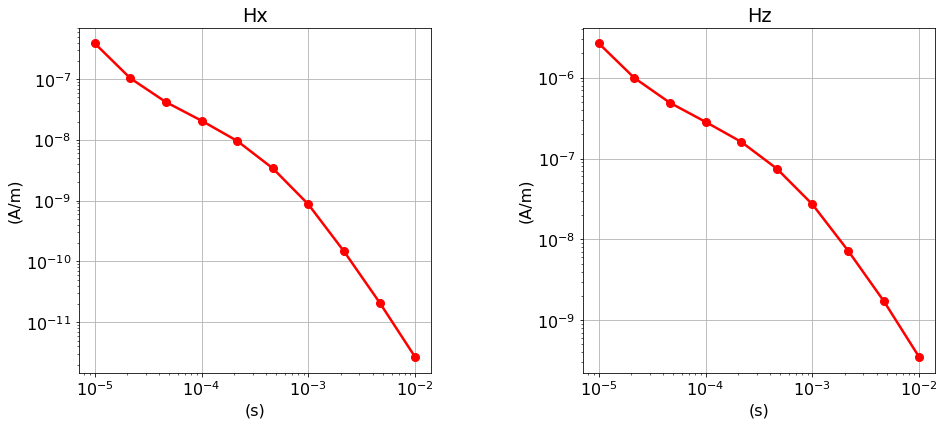

In [10]:
fig = plt.figure(figsize=(14, 6))
lw = 2.5
ms = 8

ax1 = 2*[None]
dpred_plotting = dpred[:, [0, 2]]

for ii, comp in enumerate(['x', 'z']):

    ax1[ii] = fig.add_axes([0.1+0.5*ii, 0.1, 0.35, 0.8])
    ax1[ii].loglog(times, dpred_plotting[:, ii], 'r-o', lw=lw, markersize=8)
    ax1[ii].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax1[ii].grid()
    ax1[ii].set_xlabel('(s)')
    ax1[ii].set_ylabel('(A/m)'.format(comp))
    ax1[ii].set_title('H{}'.format(comp))

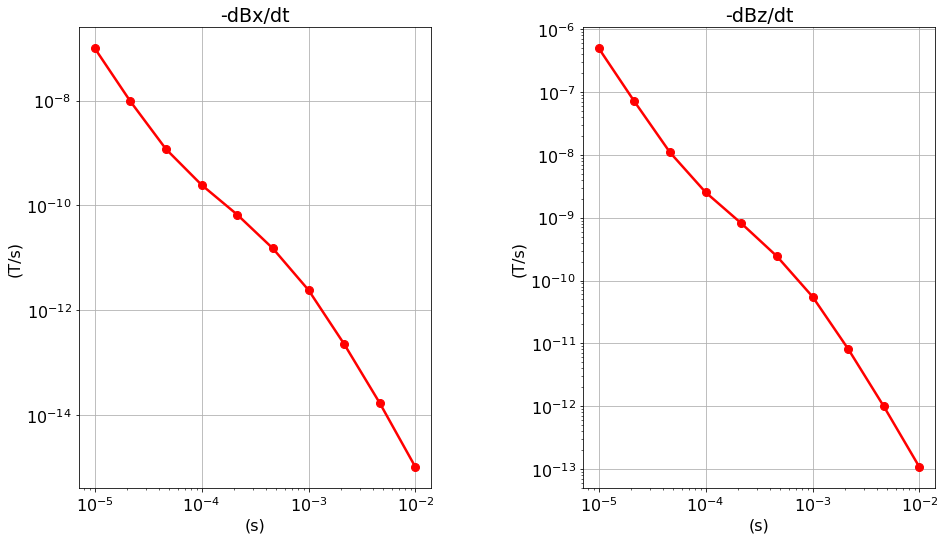

In [11]:
fig = plt.figure(figsize=(14, 8))
lw = 2.5
ms = 8

ax1 = 2*[None]
dpred_plotting = dpred[:, [3, 5]]

for ii, comp in enumerate(['x', 'z']):

    ax1[ii] = fig.add_axes([0.1+0.5*ii, 0.1, 0.35, 0.8])
    ax1[ii].loglog(times, -dpred_plotting[:, ii], 'r-o', lw=lw, markersize=8)
    ax1[ii].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax1[ii].grid()
    ax1[ii].set_xlabel('(s)')
    ax1[ii].set_ylabel('(T/s)'.format(comp))
    ax1[ii].set_title('-dB{}/dt'.format(comp))